In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyampute.exploration.mcar_statistical_tests import MCARTest
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

In [59]:
# Load the dataset
df = pd.read_csv('../data/stroke_dataset.csv')

In [60]:
# look at the dataset
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [61]:
# some of these variables are categorical, so we need to convert them to numerical values before we can perform the imputation
df = pd.get_dummies(df, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

In [62]:
np.random.seed(91) # for reproducibility

# Perform Little’s MCAR test, which tests the null hypothesis that the data is Missing Completely at Random (MCAR)
mt = MCARTest(method="little")
p_value = mt.little_mcar_test(df)

print(f"Little’s MCAR test p‑value: {p_value:.4f}") # just to see the p-value, we'll print it here

if p_value > 0.05: # if the p-value is greater than 0.05, we fail to reject the null hypothesis, which means that the data is likely MCAR
    print("MCAR cannot be rejected")
else:
    print("Data is likely not MCAR")

Little’s MCAR test p‑value: 0.0000
Data is likely not MCAR


In [63]:
X = df.drop("stroke", axis=1)
y = df["stroke"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [64]:
# We will proceed with using MICE imputation. This may be quite a lot of predictors, and runs the risk of overfitting
# If the data performs poorly on the test, we may want to consider using a simpler imputation method, such as mean imputation, or using fewer predictors in the MICE imputation.
columns_to_impute = ['bmi', 'age', 'avg_glucose_level', 
                     'gender_Male', 'gender_Female',
                     'ever_married_Yes', 'ever_married_No', 
                     'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'work_type_Govt_job', 'work_type_Never_worked',
                     'Residence_type_Urban', 'Residence_type_Rural', 
                     'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']

imputer = IterativeImputer(
    random_state=91,      # for reproducibility
    max_iter=10,          # number of MICE iterations
    sample_posterior=True # adds stochasticity for multiple imputation
)

# Fit the imputer
imputer.fit(X_train[columns_to_impute])

X_train_imputed = X_train.copy()
X_train_imputed[columns_to_impute] = imputer.transform(X_train[columns_to_impute])

X_test_imputed = X_test.copy()
X_test_imputed[columns_to_impute] = imputer.transform(X_test[columns_to_impute])

train_df = X_train_imputed.copy()
train_df['stroke'] = y_train.values

test_df = X_test_imputed.copy()
test_df['stroke'] = y_test.values

# Convert back to DataFrame
# imputed_df = pd.DataFrame(imputed_array, columns=columns_to_impute)

In [65]:
# check the imputed dataframe
train_df['bmi_original'] = df['bmi'].copy() # add the original bmi column for comparison
test_df['bmi_original'] = df['bmi'].copy() # same for both train and test dfs

# create a mask to identify which values were imputed (i.e., which values were originally missing) 
train_imputed_mask = train_df['bmi_original'].isna()
test_imputed_mask = test_df['bmi_original'].isna()

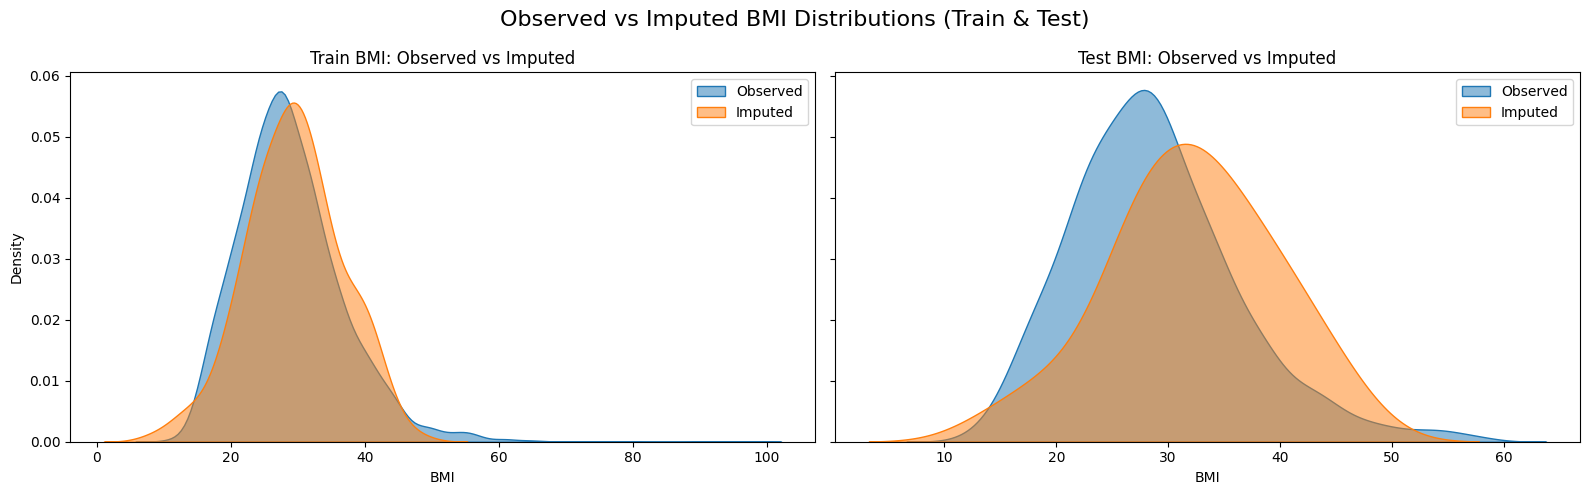

In [66]:
# we will be making KDE plots here to compare the distribution of the original vs imputed bmi values
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

# ---- Train plot ----
# For the first plot, loc pulls the location of every entry that 
# is NOT in the train_imputed_mask, that is to say, all the observed values that were not imputed.
# That's what the ~ operator does, in this case.
# For the second plot 'Imputed', we use the imputed_mask as is, to provide a plot of all the original 
# BMI values that were missing from the outset.
sns.kdeplot(
    data=train_df.loc[~train_imputed_mask], 
    x='bmi',
    fill=True,
    alpha=0.5, # alpha just makes it a little more transparent in visuals
    label='Observed',
    ax=axes[0]
)
sns.kdeplot(
    data=train_df.loc[train_imputed_mask],
    x='bmi',
    fill=True,
    alpha=0.5,
    label='Imputed',
    ax=axes[0]
)
axes[0].set_title('Train BMI: Observed vs Imputed')
axes[0].set_xlabel('BMI')
axes[0].set_ylabel('Density')
axes[0].legend()

# ---- Test plot ----
# Same idea as above, but for the test set instead.
sns.kdeplot(
    data=test_df.loc[~test_imputed_mask],
    x='bmi',
    fill=True,
    alpha=0.5,
    label='Observed',
    ax=axes[1]
)
sns.kdeplot(
    data=test_df.loc[test_imputed_mask],
    x='bmi',
    fill=True,
    alpha=0.5,
    label='Imputed',
    ax=axes[1]
)
axes[1].set_title('Test BMI: Observed vs Imputed') # setting titles and axis labels for readability
axes[1].set_xlabel('BMI')
axes[1].legend()

plt.suptitle('Observed vs Imputed BMI Distributions (Train & Test)', fontsize=16)
plt.tight_layout()
plt.show()

# the output suggests that the imputed bmi values have a similar distribution to the observed bmi values, 
# which is a good sign that the imputation has been successful in capturing the underlying distribution of the data.
# always be careful of overfitting, though.

             Feature  Importance
1                age    0.315762
4  avg_glucose_level    0.020544
5                bmi    0.008636


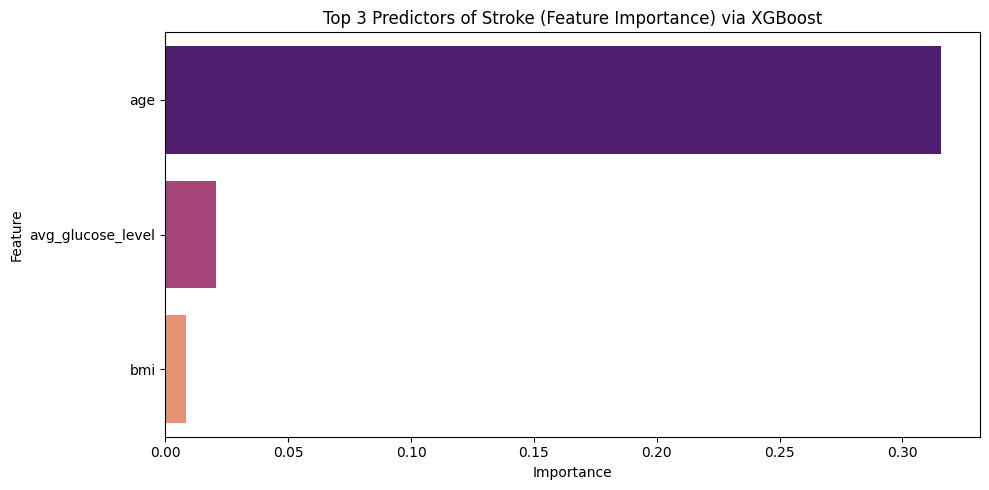

In [67]:
model = XGBClassifier(
    objective='binary:logistic', # binary classification for stroke prediction (0 and 1)
    n_estimators=400,       # more trees for better performance
    learning_rate=0.03,      # small for stability
    max_depth=3,             # shallow trees reduce overfitting
    min_child_weight=5,     # more samples per leaf to prevent overfitting
    subsample=0.8,          # use 80% of data for each tree to prevent overfitting
    colsample_bytree=0.8,   # use 80% of features for each tree to prevent overfitting
    gamma=0.5,              # minimum loss reduction to make a split, helps with regularization
    reg_lambda=1,           
    reg_alpha=0.1,          
    scale_pos_weight= len(y[y == 0]) / len(y[y == 1]), # handle class imbalance
    eval_metric='auc',       # better than logloss here
    random_state=42
)

model.fit(X_train_imputed, y_train,
           eval_set=[(X_test_imputed, y_test)], verbose=False)

results = permutation_importance(
    model,
    X_test_imputed,
    y_test,
    n_repeats=30,
    random_state=42,
    scoring='roc_auc'
)

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': results.importances_mean
}).sort_values(by='Importance', ascending=False)

print(importance_df.head(3))

plt.figure(figsize=(10, 5))
sns.barplot(data=importance_df.head(3), x='Importance', y='Feature', palette='magma', hue='Feature', legend=False)
plt.title('Top 3 Predictors of Stroke (Feature Importance) via XGBoost')
plt.tight_layout()
plt.savefig('top_3_predictors_xgboost.png')

In [68]:
# Predict probabilities for the positive class
y_pred_proba = model.predict_proba(X_test_imputed)[:, 1]

# Compute ROC AUC
auc = roc_auc_score(y_test, y_pred_proba)
print("Random Forest ROC AUC:", auc)

# ROC AUC of 0.84 is actually quite good here, because it means that the model
# assigns a higher probability of stroke to an actual stroke patient 84% of the time.
# Age is VERY heavily favoured, as also suggested in Naveen's work.  

Random Forest ROC AUC: 0.8400823045267489


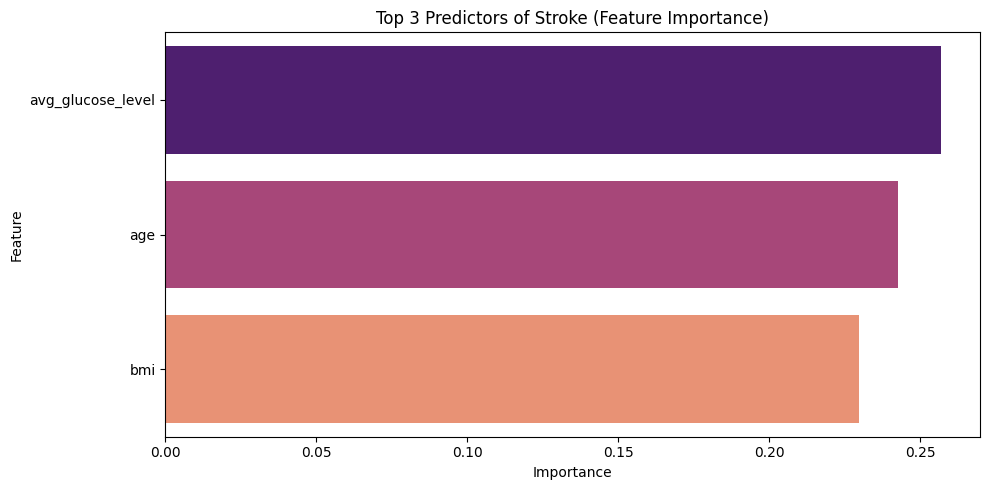

In [69]:
rf = RandomForestClassifier(n_estimators=100, random_state=91)
rf.fit(X_train_imputed.drop(columns=['id']), y_train)

importances = pd.DataFrame({
    'Feature': X_train_imputed.drop(columns=['id']).columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(data=importances.head(3), x='Importance', y='Feature', palette='magma', hue='Feature', legend=False)
plt.title('Top 3 Predictors of Stroke (Feature Importance)')
plt.tight_layout()
plt.savefig('top_3_predictors_rf.png')

In [70]:
# Predict probabilities for the positive class
y_pred_proba = rf.predict_proba(X_test_imputed.drop(columns=['id']))[:, 1]

# Compute ROC AUC
auc = roc_auc_score(y_test, y_pred_proba)
print("Random Forest ROC AUC:", auc)

# ROC AUC of 0.77 is less good than XGBoost here, but it does mean that the model
# assigns a higher probability of stroke to an actual stroke patient 77% of the time.
# Note that this weights Age and BMI much more evenly with glucose level than XGBoost,
# which heavily favours age over everything else. 

Random Forest ROC AUC: 0.7676748971193416



Training GradientBoosting...
GradientBoosting ROC AUC: 0.832
Top 3 Features:
              Feature  Importance
0                age    0.291778
2      heart_disease    0.004532
3  avg_glucose_level    0.004028


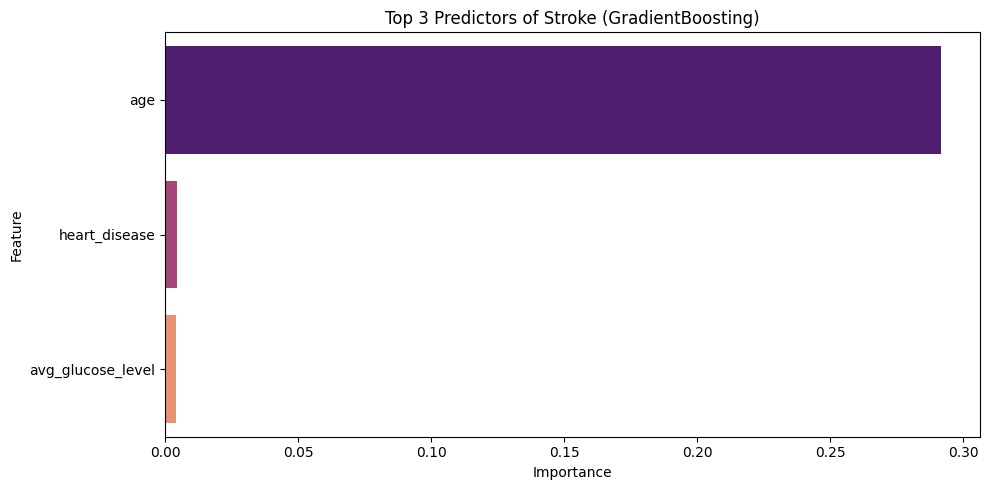


Training LightGBM...
LightGBM ROC AUC: 0.839
Top 3 Features:
              Feature  Importance
0                age    0.319202
4                bmi    0.012151
3  avg_glucose_level    0.011715


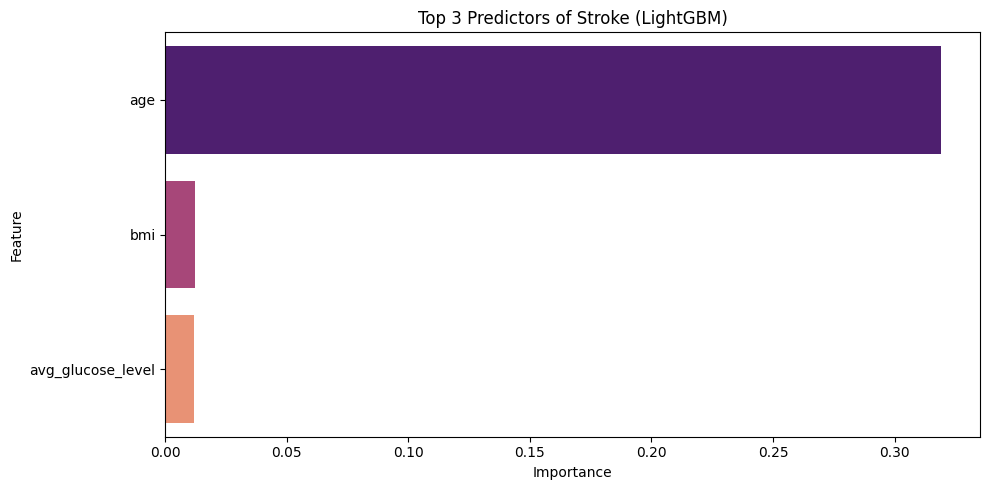


Training CatBoost...
CatBoost ROC AUC: 0.838
Top 3 Features:
              Feature  Importance
0                age    0.320702
3  avg_glucose_level    0.021209
4                bmi    0.002208


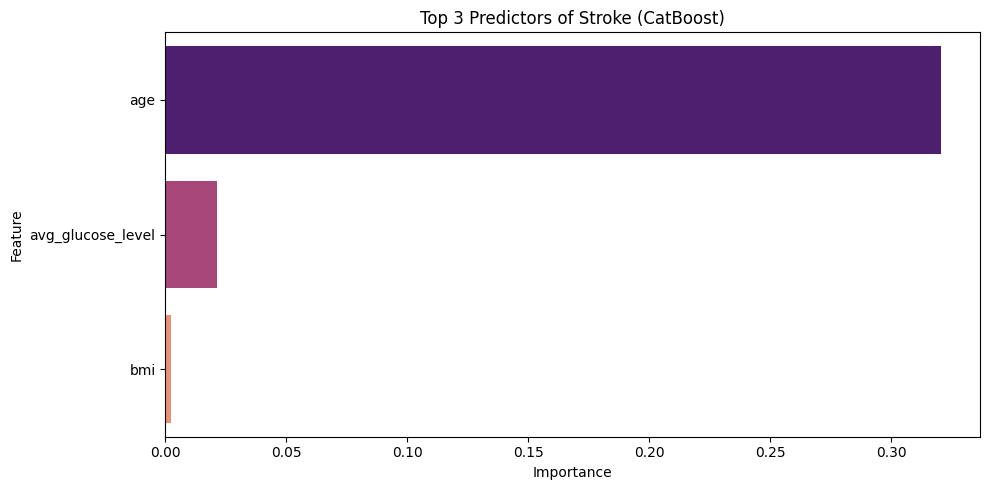

In [71]:
# Dictionary to store models
models = {
    "GradientBoosting": GradientBoostingClassifier(
        n_estimators=400,
        learning_rate=0.03,
        max_depth=3,
        subsample=0.8,
        random_state=42
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=400,
        learning_rate=0.03,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        is_unbalance=True,  # handles class imbalance
        random_state=42,
        verbose=-1
    ),
    "CatBoost": CatBoostClassifier(
        iterations=400,
        learning_rate=0.03,
        depth=3,
        verbose=0,
        class_weights=[1, len(y_train[y_train==0]) / len(y_train[y_train==1])],
        random_state=42
    )
}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train
    model.fit(X_train_imputed.drop(columns=['id'], errors='ignore'), y_train)
    
    # ROC AUC on test set
    y_pred_proba = model.predict_proba(X_test_imputed.drop(columns=['id'], errors='ignore'))[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"{name} ROC AUC: {auc:.3f}")
    
    # Permutation importance using ROC AUC
    results = permutation_importance(
        model,
        X_test_imputed.drop(columns=['id'], errors='ignore'),
        y_test,
        n_repeats=30,
        random_state=42,
        scoring='roc_auc'
    )
    
    importance_df = pd.DataFrame({
        'Feature': X_train_imputed.drop(columns=['id'], errors='ignore').columns,
        'Importance': results.importances_mean
    }).sort_values(by='Importance', ascending=False)
    
    print("Top 3 Features:\n", importance_df.head(3))
    
    # Plot top 3 features
    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=importance_df.head(3),
        x='Importance',
        y='Feature',
        palette='magma',
        hue='Feature',
        legend=False
    )
    plt.title(f'Top 3 Predictors of Stroke ({name})')
    plt.tight_layout()
    plt.savefig(f'top_3_predictors_{name.lower()}.png')
    plt.show()

In [72]:
# Some interesting points to go through:
# All 3 of these models hover around an ROC AUC score of 0.83, which is pretty good for such a small dataset.
# Gradient Boosting is interesting in that it seems to favour heart disease incidence over BMI.
# All 3 of these models heavily favour age, just like XGBoost.